In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import display
from pathlib import Path

from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

from collections import Counter
from ipywidgets import interact, fixed

In [ ]:
def calc_accuracy(y_true, y_pred, metric='mae'):
    if metric == 'mae':
        acc = mean_absolute_error(y_true, y_pred)
    elif metric == 'r2':
        acc = r2_score(y_true, y_pred)
    elif metric == 'rmse':
        acc = root_mean_squared_error(y_true, y_pred)

    return acc

def plot_model_boxplots(df: pd.DataFrame, metric_name= str, lower_is_better=False):
    """
    Plots boxplots sorted by median performance for each model using seaborn and
    annotates each box with its median value.

    Parameters:
        df (pd.DataFrame): Rows = datasets, Columns = models, Values = performance metric.
        metric_name (str): Name of the metric to label the y-axis (e.g., 'R²', 'RMSE').
        lower_is_better (bool): Used in the title to indicate desired metric direction.
    """
    # Melt the DataFrame into long format for seaborn
    melted = df.reset_index(drop=True).melt(var_name='Model', value_name=metric_name)

    # Compute median performance for sorting and annotation
    medians = melted.groupby('Model')[metric_name].median().sort_values(ascending= lower_is_better)
    model_order = medians.index.tolist()

    # Set style
    sns.set(style="whitegrid")

    # Create the boxplot with sorted model order
    plt.figure(figsize=(10, 6))
    ax = sns.boxplot(
        data=melted,
        x='Model',
        y=metric_name,
        order=model_order,
        showmeans=True,
        meanprops={"marker": "o", "markerfacecolor": "black", "markeredgecolor": "black"}
    )

    # Annotate each box with the median value
    for i, model in enumerate(model_order):
        median_val = medians[model]
        ax.text(i, median_val, f'{median_val:.3f}', 
                ha='center', va='bottom', fontsize=9, fontweight='bold', color='black')

    # Annotate title
    direction = "Lower is better" if lower_is_better else "Higher is better"
    plt.title(f'Model Performance ({metric_name}) - {direction}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def compute_cumulative_top_k(df: pd.DataFrame, k: int = None, lower_is_better: bool = True) -> pd.DataFrame:
    """
    Compute how often each model was in the Top-k positions, cumulatively, with options for k and lower_is_better.
    
    Parameters:
        df (pd.DataFrame): DataFrame where each column is a model, 
                           each row is a dataset, and values are regression metrics (e.g., R²).
        k (int, optional): The number of top positions to count (default is None, which counts up to all available models).
        lower_is_better (bool, optional): If True, assumes lower values are better (default is True).
    
    Returns:
        pd.DataFrame: A DataFrame showing cumulative Top-k counts per model.
    """
    # Rank models in descending or ascending order based on 'higher_is_better' parameter
    ranks = df.rank(axis=1, method='min', ascending= lower_is_better)
    
    # Set k to the number of models if None
    if k is None:
        k = len(df.columns)
    
    # Prepare result container
    top_k_counts = pd.DataFrame(index=df.columns)
    
    # Calculate cumulative counts for Top-1, Top-2, ..., Top-k
    for i in range(1, k + 1):
        in_top_k = (ranks <= i).sum()
        top_k_counts[f'Top-{i}'] = in_top_k
    
    # Return the DataFrame with cumulative top-k counts per model
    return top_k_counts

def compare_two_models(df: pd.DataFrame, model_1: str, model_2: str, lower_is_better=True) -> dict:
    """
    Compares two models across datasets and counts how often each is better.
    
    Parameters:
        df (pd.DataFrame): Rows = datasets, Columns = models.
        model_1 (str): First model name.
        model_2 (str): Second model name.
        higher_is_better (bool): Whether higher values are better (e.g., RÂ²) or worse (e.g., RMSE).
        
    Returns:
        dict: Counts of how often model_1 wins, model_2 wins, and ties.
    """
    assert model_1 in df.columns and model_2 in df.columns, "Both model names must be in the DataFrame."

    m1_vals = df[model_1]
    m2_vals = df[model_2]
    
    if lower_is_better:
        m1_better = (m1_vals < m2_vals).sum()
        m2_better = (m2_vals < m1_vals).sum()
    else:
        m1_better = (m1_vals > m2_vals).sum()
        m2_better = (m2_vals > m1_vals).sum()

    ties = (m1_vals == m2_vals).sum()

    return {
        f"{model_1} better": m1_better.item(),
        f"{model_2} better": m2_better.item(),
        "Ties": ties.item()
    }


def compare_models(model1, model2, result_df, metric):
        # Get comparison statistics
        res = compare_two_models(result_df, model_1=model1, model_2=model2, lower_is_better=lower_is_better(metric))
        
        # Create figure and axes
        fig, ax = plt.subplots(figsize=(8, 4))  # Wider figure to accommodate text
        
        # Create boxplot
        sns.boxplot(data=result_df[[model1, model2]], ax=ax)
        plt.title(f'Performance Comparison: {model1} vs {model2}')
        plt.ylabel(f'{metric}')
        
        # Format the comparison text
        comparison_text = f"{model1} better: {res[f'{model1} better']}\n{model2} better: {res[f'{model2} better']}\nTies: {res['Ties']}"
        
        # Add explanatory text if these are the consensus models
        if model1 == "Best" or model2 == "Best" or model1 == "All" or model2 == "All":
            explanation = "Best: consensus of top 10 models\nAll: consensus of all models\n\n"
            comparison_text = explanation + comparison_text
        
        # Add text to the right of the plot
        ax.text(1.05, 0.5, comparison_text, 
                transform=ax.transAxes,  # Use axes coordinates
                va='center',  # Vertically center the text
                fontsize=10,
                bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
        
        # Adjust layout to make room for the text
        plt.tight_layout()
        plt.subplots_adjust(right=0.7)  # Make room on the right for the text
        
        plt.show()


def lower_is_better(metric):
    if metric == "r2":
        return False  # For R², higher is better
    elif metric == 'mae' or metric == 'rmse':
        return True   # For MAE/RMSE, lower is better
    else:
        raise ValueError(f"Unknown metric: {metric}")





### Set up

In [13]:
bench_result = Path("benchmark_model_consensus").resolve()
os.listdir(bench_result)
bench_folder = os.path.join(bench_result, "chembl")
bench_folder

'C:\\Users\\micha\\Desktop\\Stacking_project\\QSARcons\\dev\\benchmark_model_consensus\\chembl'

In [14]:
metric = "mae"

### Models perfomance summury

In [15]:
# TODO get rid of scientific nitation like -1.422665e+09 for stable mean calcualtion

result_df = []

for bench_dataset in os.listdir(bench_folder):
    traindefault_df = pd.read_csv(os.path.join(bench_folder, bench_dataset, "default_train.csv"))
    testdefault_df = pd.read_csv(os.path.join(bench_folder, bench_dataset, "default_test.csv"))
    train_df = pd.read_csv(os.path.join(bench_folder, bench_dataset, "train.csv"))
    test_df = pd.read_csv(os.path.join(bench_folder, bench_dataset, "test.csv"))
    
    # Calculate accuracy metric for each consensus/stacking method
    acc_test = test_df.drop(columns='Y_TRUE').apply(lambda col: calc_accuracy(test_df['Y_TRUE'], col, metric=metric))

    # Handle different metrics appropriately
    if metric == "r2":
        # For R², exclude rows with negative values (worse than baseline)
        if (acc_test > 0).all():
            result_df.append(acc_test.round(3))
    
    elif metric == "mae":
        # For MAE, exclude rows with extremely large values (potential errors)
        # Calculate the range of Y_TRUE to establish a reasonable threshold
        y_range = test_df['Y_TRUE'].max() - test_df['Y_TRUE'].min()
        # Set a threshold of 3x the Y range - adjust this based on your data
        if (acc_test < 3 * y_range).all():
            result_df.append(acc_test.round(3))
    
    elif metric == "rmse":
        # For RMSE, similar to MAE but with a slightly higher threshold
        # as RMSE values are typically larger than MAE
        y_range = test_df['Y_TRUE'].max() - test_df['Y_TRUE'].min()
        # Set a threshold of 5x the Y range - adjust based on your data
        if (acc_test < 5 * y_range).all():
            result_df.append(acc_test.round(3))
result_df = pd.DataFrame(result_df)
result_df

,Best,All,Random,Systematic,Genetic,StackingLinearRegression,StackingRandomForestRegressor,StackingMLPRegressor,StackingRidge,StackingSVR,StackingKNeighborsRegressor
0,0.465,0.584,0.498,0.475,0.465,0.473,0.459,0.563,0.470,0.487,0.537
1,0.390,0.414,0.420,0.393,0.397,0.536,0.422,0.623,0.513,0.425,0.420
2,0.425,0.542,0.433,0.425,0.418,0.700,0.446,1.459,0.704,0.721,0.531
3,0.512,0.769,0.598,0.541,0.498,0.689,0.533,2.366,0.666,1.207,0.757
4,0.471,0.495,0.903,0.477,0.470,0.713,0.515,1.034,0.697,0.930,0.572
...,...,...,...,...,...,...,...,...,...,...,...
161,0.573,0.621,0.657,0.566,0.555,0.726,0.626,0.656,0.693,0.605,0.626
162,0.527,0.582,0.772,0.538,0.478,0.864,0.567,0.649,0.781,0.601,0.604
163,0.483,0.554,0.568,0.486,0.468,0.665,0.483,0.747,0.578,0.545,0.527
164,0.519,0.531,0.607,0.498,0.472,0.589,0.524,0.657,0.565,0.576,0.564


In [16]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

def plot_single_model(model_name, metric, result_df):
    plt.figure(figsize=(6,4))
    sns.boxplot(y=result_df[model_name])
    plt.title(f'Performance Distribution: {model_name}')
    plt.ylabel(f'{metric}')
    plt.show()

model_dropdown = widgets.Dropdown(
    options=result_df.columns.tolist(),
    description='Model:'
)

controls = widgets.VBox([model_dropdown])

interactive_plot = widgets.interactive_output(
    plot_single_model,
    {'model_name': model_dropdown, 'metric': widgets.fixed(metric), 'result_df': widgets.fixed(result_df)}
)

display(controls, interactive_plot)

Output()

### 1. Mean accuracy

In [17]:
result_df.mean().to_frame().sort_values(by=0, ascending=lower_is_better(metric)).round(2)

,0
Genetic,0.46
Best,0.47
Systematic,0.48
StackingRandomForestRegressor,0.49
StackingKNeighborsRegressor,0.56
StackingRidge,0.60
StackingLinearRegression,0.63
StackingSVR,0.64
Random,0.69
All,0.80


### 2. Accuracy boxplot

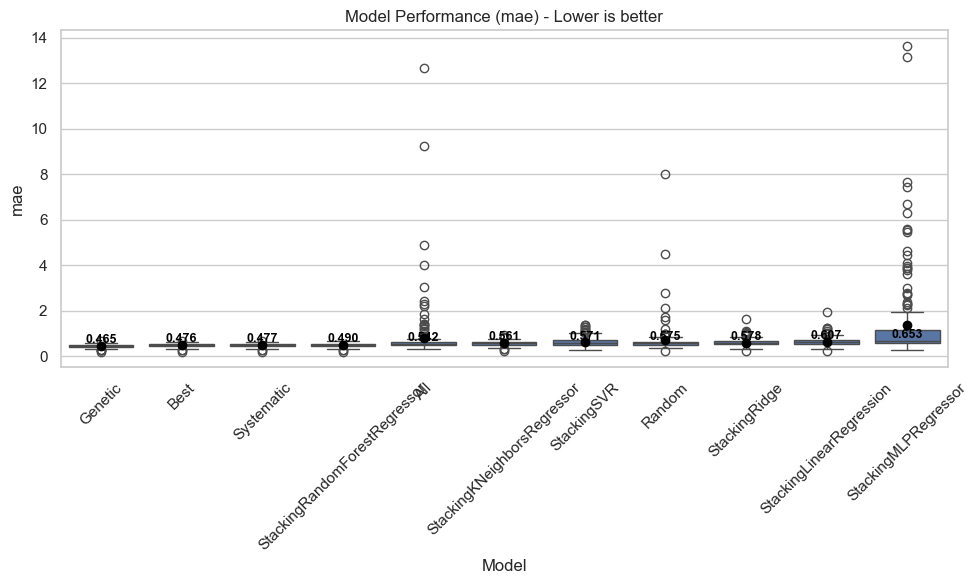

In [18]:
plot_model_boxplots(result_df, metric_name=f'{metric}', lower_is_better=lower_is_better(metric))

### 3. Top-N statistics

In [ ]:
output_widget = widgets.Output()

def show_top_k(k, metric):
    with output_widget:
        output_widget.clear_output(wait=True)
        pair_df = compute_cumulative_top_k(
            result_df, k=k, lower_is_better=lower_is_better(metric)
        )
        display(pair_df.sort_values(by=f"Top-{k}", ascending= lower_is_better(metric)))

k_slider = widgets.IntSlider(
    value=1, min=1, max=len(result_df.columns), step=1, description='Top-K:'
)

# This binds the function to the widgets and uses your output_widget
controls = widgets.HBox([k_slider])
display(controls, output_widget)
widgets.interactive_output(show_top_k, {'k': k_slider, 'metric': fixed(metric)})

Output()

Output()

### 4. Pair accuracy comparison

In [ ]:
# Create an Output widget to contain the plot
output = widgets.Output()
def compare_models(model1, model2, result_df, metric, output):
    with output:
        output.clear_output(wait=True)  # Clear previous output
        
        # Get comparison statistics
        res = compare_two_models(result_df, model_1=model1, model_2=model2, 
                               lower_is_better=lower_is_better(metric))
        
        # Create figure and axes
        fig, ax = plt.subplots(figsize=(8, 4))
        
        # Create boxplot
        sns.boxplot(data=result_df[[model1, model2]], ax=ax)
        plt.title(f'Performance Comparison: {model1} vs {model2}')
        plt.ylabel(f'{metric}')
        
        # Format comparison text
        comparison_text = (
            f"{model1} better: {res[f'{model1} better']}\n"
            f"{model2} better: {res[f'{model2} better']}\n"
            f"Ties: {res['Ties']}"
        )
        
        # Add explanatory text for consensus models
        if model1 in ["Best", "All"] or model2 in ["Best", "All"]:
            explanation = "Best: consensus of top 10 models\nAll: consensus of all models\n\n"
            comparison_text = explanation + comparison_text
        
        # Add text annotation
        ax.text(1.05, 0.5, comparison_text, 
                transform=ax.transAxes, 
                va='center', 
                fontsize=10,
                bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
        
        # Adjust layout
        plt.tight_layout()
        plt.subplots_adjust(right=0.7)
        plt.show()

# Create dropdown widgets
model1_dropdown = widgets.Dropdown(options=result_df.columns.tolist(), description='Model 1:')
model2_dropdown = widgets.Dropdown(options=result_df.columns.tolist(), description='Model 2:')

# Create interactive output
controls = widgets.HBox([model1_dropdown, model2_dropdown])
interactive_plot = widgets.interactive_output(
    compare_models,
    {
        'model1': model1_dropdown,
        'model2': model2_dropdown,
        'result_df': widgets.fixed(result_df),
        'metric': widgets.fixed(metric)
    }
)

# Display controls and output
display(controls, output)


Output()

### 5. CI Diagram from JCIM paper on MIL
### TODO: DZ -> I will find the code for building this diagram